In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
import torch
from torch.cuda.amp import autocast
import numpy as np
import matplotlib.pyplot as plt

In [2]:
encoder_layer = torch.nn.TransformerEncoderLayer(d_model=512, nhead=8)
TransformerEncoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=6) # TransformerEncoder is a stack of N encoder layers.
Transformer = torch.nn.Transformer(d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6)
print(encoder_layer)
print(TransformerEncoder)
print(Transformer)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (linear1): Linear(in_features=512, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=2048, out_features=512, bias=True)
  (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)
TransformerEncoder(
  (layers): ModuleList(
    (0-5): 6 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (linear1): Linear(in_features=512, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=512, bias=True)
      (norm1): LayerNorm((5

In [3]:
class TransformerAE(torch.nn.Module):
  def __init__(self, in_dim, d_model):
    super(TransformerAE, self).__init__()
    self.linear1 = torch.nn.Linear(in_dim, d_model)
    self.transformer1 = torch.nn.TransformerEncoderLayer(d_model=d_model, nhead=8, batch_first=True)
    self.linear3 = torch.nn.Linear(d_model, d_model//4)
    self.linear4 = torch.nn.Linear(d_model//4, d_model)
    self.transformer2 = torch.nn.TransformerEncoderLayer(d_model=d_model, nhead=8, batch_first=True)
    self.activation = torch.nn.ReLU()
    self.linear2 = torch.nn.Linear(d_model, in_dim)

  def forward(self, x):
    #x = self.linear1(x)
    #x = self.activation(x)
    x = self.transformer1(x)
    #x = self.linear3(x)
    #x = self.linear4(x)
    x = self.transformer2(x)
    #x = self.activation(x)
    #x = self.linear2(x)

    return x

(2, 5632)
(64, 2)


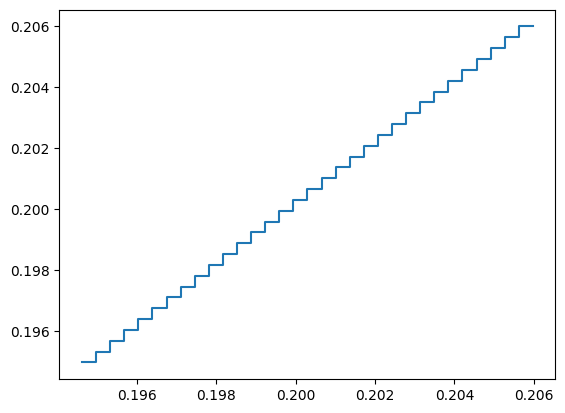

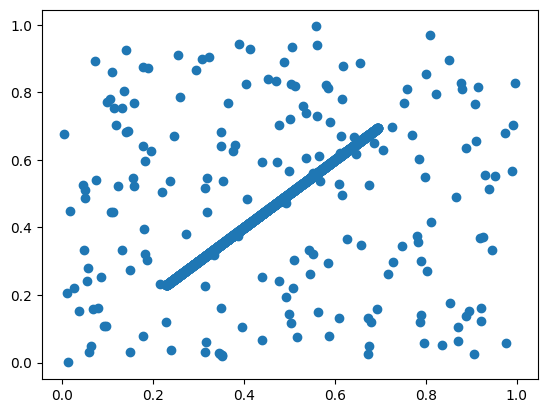

In [6]:
import random
def pattern_gen(num=64, dim=128, pattern_array_all=None):
  pattern_array_all = []
  norm = dim
  shift = np.random.rand(num)/2
  for n in range(num):
    pattern_array = []
    #pattern_array.append([shift[n]+0/norm,shift[n]+0/norm])
    for i in range((dim)//2):
      pattern_array.append([shift[n]+i/norm,shift[n]+(i+1)/norm])
      pattern_array.append([shift[n]+(i+1)/norm,shift[n]+(i+1)/norm])
    #pattern_array.append([shift[n]+((dim-2)//2)/norm,shift[n]+0/norm])
    pattern_array_all.append(np.array(pattern_array).flatten())
  return np.array(pattern_array_all)

def random_mask(pattern_array_all, random_num=0):
  pattern_array_all_rand = np.copy(pattern_array_all)
  for pattern_array in pattern_array_all_rand:
    ramdom_list = random.sample(range(pattern_array.size), random_num)
    for i in range(pattern_array.size):
      if i in ramdom_list:
        pattern_array[i] = 0
  return pattern_array_all_rand

def erase_polygon_segment(pattern_array_all, random_num=0):
  pattern_array_all_rand = np.copy(pattern_array_all)
  for pattern_array in pattern_array_all_rand:
    ramdom_list = random.sample(range(44), random_num)
    for i in range(random_num):
      pattern_array[i*128:(i+1)*128] = np.random.rand((128)) #0
  return pattern_array_all_rand



from matplotlib.patches import Polygon

pts = pattern_gen(num=2, dim=64*44)
pattern_array_all_rand = random_mask(pts, random_num=5*44)
print(pts.shape)
points = np.reshape(pts[0],(44, -1, 2))[0]
print(points.shape)
#p = Polygon(points) # facecolor = 'k'
#fig,ax = plt.subplots()
#ax.add_patch(p)
plt.figure()
plt.plot(points[:,0], points[:,1])

pattern_array_all_erase = erase_polygon_segment(pts, random_num=3)
points = np.reshape(pattern_array_all_erase[0],(-1, 2))
plt.figure()
plt.plot(points[:,0], points[:,1], 'o')

In [ ]:
device = 'cpu'
model = TransformerAE(in_dim=128, d_model=128).to(device)

'''
for param in model.parameters():
    param.requires_grad = False

for param in model.transformer1.self_attn.parameters():
    param.requires_grad = True
for param in model.transformer2.self_attn.parameters():
    param.requires_grad = True
'''

optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
loss_fn = torch.nn.L1Loss()
train_loss = []
model.train()
for i in range(100):
  #rand = torch.rand(64, 22, 128)
  reconstruct = pattern_gen(num=64, dim=64*44) # torch.cat((rand, rand), 1)
  fake_pattern = erase_polygon_segment(reconstruct, random_num=15) # random_mask(reconstruct, random_num=10*44) #torch.cat((rand, torch.ones(64, 22, 128)), 1)

  reconstruct = np.reshape(reconstruct,(64, 44, 128))
  fake_pattern = np.reshape(fake_pattern,(64, 44, 128))

  reconstruct = torch.Tensor(reconstruct)
  fake_pattern = torch.Tensor(fake_pattern)
  optimizer.zero_grad()
  with autocast():
    out = model(fake_pattern.to(device))
    loss = loss_fn(out, reconstruct)
  loss.backward()
  optimizer.step()
  train_loss.append(loss.item())
  total_train_loss = sum(train_loss) / len(train_loss)
  print(f"Loss: {total_train_loss:.4f}")

<ipython-input-303-ed52eb925d52>:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Loss: 0.8954
Loss: 0.8860
Loss: 0.8435
Loss: 0.7961
Loss: 0.7575
Loss: 0.7297
Loss: 0.7057
Loss: 0.6873
Loss: 0.6721
Loss: 0.6604
Loss: 0.6499
Loss: 0.6415
Loss: 0.6325
Loss: 0.6266
Loss: 0.6207
Loss: 0.6155
Loss: 0.6102
Loss: 0.6054
Loss: 0.6009
Loss: 0.5977
Loss: 0.5946
Loss: 0.5904
Loss: 0.5872
Loss: 0.5835
Loss: 0.5810
Loss: 0.5790
Loss: 0.5767
Loss: 0.5745
Loss: 0.5730
Loss: 0.5712
Loss: 0.5696
Loss: 0.5688
Loss: 0.5677
Loss: 0.5665
Loss: 0.5646
Loss: 0.5639
Loss: 0.5629
Loss: 0.5621
Loss: 0.5613
Loss: 0.5599
Loss: 0.5590
Loss: 0.5582
Loss: 0.5571
Loss: 0.5567
Loss: 0.5557
Loss: 0.5549
Loss: 0.5544
Loss: 0.5541
Loss: 0.5527
Loss: 0.5521
Loss: 0.5514
Loss: 0.5510
Loss: 0.5503
Loss: 0.5494
Loss: 0.5492
Loss: 0.5480
Loss: 0.5482
Loss: 0.5478
Loss: 0.5474
Loss: 0.5468
Loss: 0.5464
Loss: 0.5457
Loss: 0.5452
Loss: 0.5447
Loss: 0.5441
Loss: 0.5437
Loss: 0.5433
Loss: 0.5428
Loss: 0.5427
Loss: 0.5422
Loss: 0.5420
Loss: 0.5414
Loss: 0.5412
Loss: 0.5410
Loss: 0.5409
Loss: 0.5406
Loss: 0.5405

KeyboardInterrupt: 

loss:  tensor(0.1848)
torch.Size([64, 44, 128])
torch.Size([64, 44, 44])


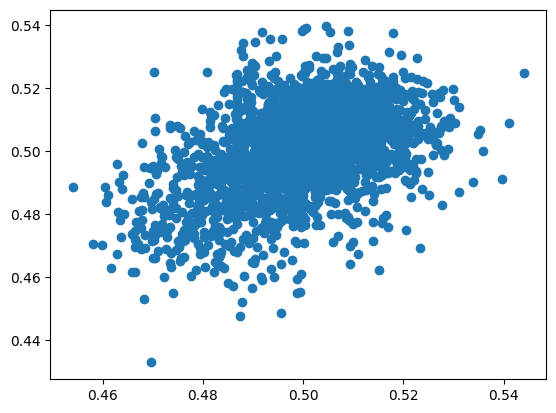

In [ ]:
from typing import Optional, Any, Union, Callable
# model = TransformerAE(in_dim=44, d_model=512).to(device)
class Model_need_weights(torch.nn.Module):
  def __init__(self, model):
    super(Model_need_weights, self).__init__()
    self.model = model
    self.model.transformer1._sa_block = self._sa_block_need_weights2
    self.model.transformer2._sa_block = self._sa_block_need_weights22

  def _sa_block_need_weights2(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor], key_padding_mask: Optional[torch.Tensor] = None, is_causal: bool = False) -> torch.Tensor:
    x = self.model.transformer1.self_attn(x, x, x,
    attn_mask=attn_mask,
    key_padding_mask=key_padding_mask,
    need_weights=True, is_causal=is_causal)[0]

    return self.model.transformer1.dropout1(x)

  def _sa_block_need_weights22(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor], key_padding_mask: Optional[torch.Tensor] = None, is_causal: bool = False) -> torch.Tensor:
    x = self.model.transformer2.self_attn(x, x, x,
    attn_mask=attn_mask,
    key_padding_mask=key_padding_mask,
    need_weights=True, is_causal=is_causal)[0]

    return self.model.transformer2.dropout1(x)



model2 = Model_need_weights(model)

def forward_pass(fake_patter, model2, layer, device):
    attn_output = []
    attn_output_weights = []

    def hook_fn_forward(module, input, output):
      attn_output.append(output[0].detach().cpu())
      attn_output_weights.append(output[1].detach().cpu())

    forward_hook = layer.register_forward_hook(hook_fn_forward)

    loss_fn = torch.nn.L1Loss()
    with torch.no_grad():
      out = model2.model(fake_pattern.to(device))
      #print("out: ", out[:,:,0:64])
      #print("out2: ", out[:,:,64::])
      # print("fake_pattern: ", fake_pattern)
      points = np.reshape(out[0],(-1, 2))
      plt.figure()
      plt.plot(points[:,0], points[:,1], 'o')
      #p = Polygon(points) # facecolor = 'k'
      #fig,ax = plt.subplots()
      #ax.add_patch(p)
      loss = loss_fn(out, fake_pattern)
      print("loss: ", loss)

    forward_hook.remove()

    attn_output = torch.cat([x for x in attn_output])
    attn_output_weights = torch.cat([x for x in attn_output_weights])
    return attn_output, attn_output_weights

layer = model2.model.transformer1.self_attn
attn_output, attn_output_weights = forward_pass(fake_pattern, model2, layer, device)
print(attn_output.size())
print(attn_output_weights.size()) # https://github.com/pytorch/pytorch/blob/main/torch/nn/functional.py # attn_output_weights = torch.bmm(q_scaled, k.transpose(-2, -1)) # # optionally average attention weights over heads

torch.Size([44, 44])


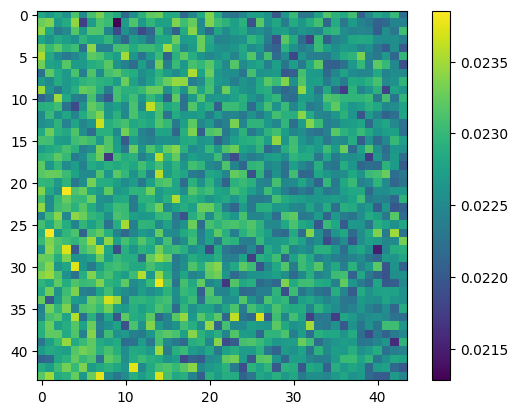

In [ ]:
attn_output_weights_avg = torch.mean(attn_output_weights, dim=0)
print(attn_output_weights_avg.size())
plt.figure()
plt.imshow(attn_output_weights_avg)
plt.colorbar()

In [ ]:
class Autoencoder(nn.Module): #整包可替換為torch.nn.Transformer <- 包含encoder和decoder
  def __init__(self, input_size, hidden_size=256):
      super(Autoencoder, self).__init__()
      self.encoder = torch.nn.Sequential(
          torch.nn.Linear(input_size, hidden_size),
          torch.nn.ReLU()
      )
      self.decoder = torch.nn.Sequential(
          torch.nn.Linear(hidden_size, input_size),
          # torch.nn.Sigmoid()
      )

  def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x

NameError: name 'nn' is not defined